# Import des librairies nécessaires 

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split


# Sommaire

1. partition du dataset (train, test) --> Done
2. best feature
2. KNeighbors

## Partition

In [59]:
data = pd.read_csv("fetal_health.csv")

data.fetal_health = pd.Categorical(data.fetal_health, categories=[1.0, 2.0, 3.0], ordered=True)

In [60]:
data_non_ordinal = data = pd.read_csv("fetal_health.csv")

In [61]:
# Création de deux DF (un de labels et un de données)
labels = data.fetal_health
clean_data = data.drop('fetal_health', axis=1)


In [62]:
print(clean_data.shape)
print(labels.shape)

(2126, 21)
(2126,)


Les dimensions sont cohérentes

In [63]:
data_train, data_test, labels_train, labels_test = train_test_split(clean_data, labels, test_size=0.2, random_state=123, shuffle=True, stratify=labels)


Création d'une partition des données avec une proportion 80/20, random state spécifié pour avoir la même partition à chauqe appel, stratify= labels pour conserver les proportions de nos labels 

In [64]:
labels_train
labels_test

915     1.0
339     3.0
1925    1.0
1277    1.0
1585    1.0
       ... 
1536    1.0
1735    1.0
454     1.0
69      1.0
1557    1.0
Name: fetal_health, Length: 426, dtype: float64

## Best feature

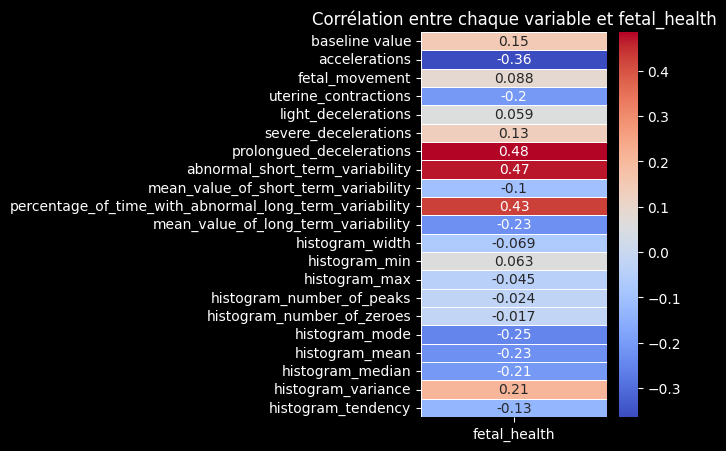

In [65]:
correlation_data = data_non_ordinal.corr()['fetal_health']

# Créez un DataFrame à partir de la série de corrélation
correlation_df = pd.DataFrame(correlation_data)
correlation_df = correlation_df.drop('fetal_health')

# Tracez la heatmap de la corrélation
plt.figure(figsize=(3, 5))
plt.grid(False)
sns.heatmap(correlation_df, cmap='coolwarm', linewidths=0.5, annot=True, )
plt.title('Corrélation entre chaque variable et fetal_health')
plt.show()

On remarque que les variables "accelerations","prolongued_decelerations", "abnormal_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability" et "mean_value_of_long_term_variability" sont celles qui sont le plus corrélé  à la santé du foetus

Nous allons regarder avec d'autres méthodes si ce sont les best features à utiliser

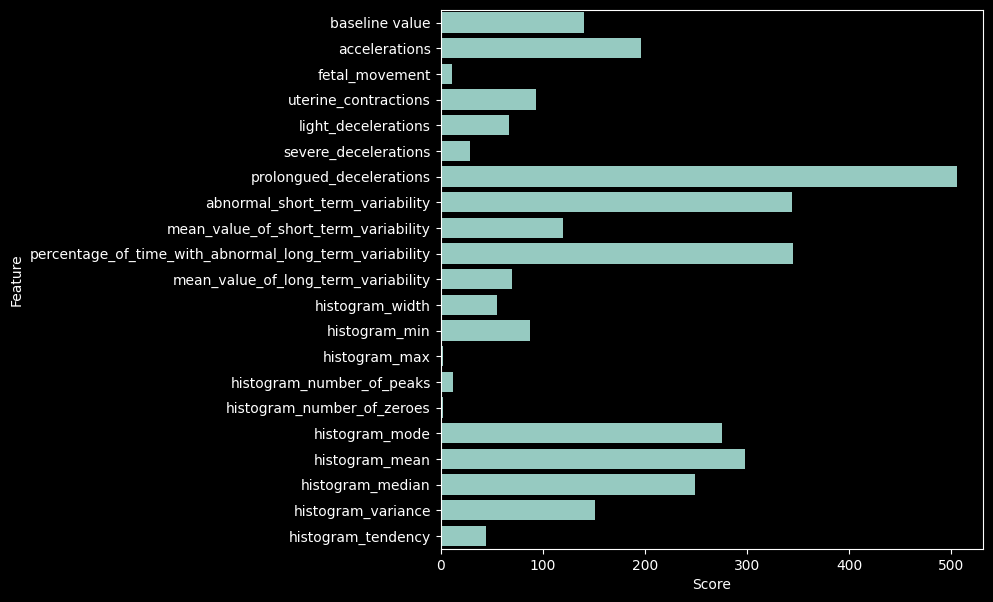

In [66]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif

X= clean_data
Y=data['fetal_health']

# f_classif correspond a un test d'anova
bestfeatures = SelectKBest(score_func=f_classif, k='all')

fit = bestfeatures.fit(X,Y)

# résultats 
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score'] 

#Visualize the feature scores
fig, ax=plt.subplots(figsize=(7,7))
plot=sns.barplot(data=featureScores, x='Score', y='Feature',linewidth=0.5, orient='h')


En faisant ce test nous réalisons une analyse de la variance entre chaque variable et nos labels. Avec cela nous calculons un score qui montre les variables qui ont eu le meilleur "score" sur le test.

In [67]:
# On selectionne les variables avec un score >= 200
selection=list(featureScores[featureScores['Score']>=200]['Feature'])
selection.append('fetal_health')

# On crée un nouveau dataset avec les variables qui nous intéressent
data_selected=data[selection]
data_selected.head()

,prolongued_decelerations,abnormal_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,histogram_mode,histogram_mean,histogram_median,fetal_health
0,0.0,73.0,43.0,120.0,137.0,121.0,2.0
1,0.0,17.0,0.0,141.0,136.0,140.0,1.0
2,0.0,16.0,0.0,141.0,135.0,138.0,1.0
3,0.0,16.0,0.0,137.0,134.0,137.0,1.0
4,0.0,16.0,0.0,137.0,136.0,138.0,1.0


On voit que les variables sélectionnées sont en parties communes à celles montrées auparavant

In [68]:
# Création de deux DF (un de labels et un de données)
labels_selected = data_selected.fetal_health
clean_data_selected = data_selected.drop('fetal_health', axis=1)

data_train_selected, data_test_selected, labels_train_selected, labels_test_selected = train_test_split(clean_data_selected, labels_selected, test_size=0.2, random_state=123, shuffle=True, stratify=labels_selected)


## KNeighbors (sans selection des var)

In [69]:
from sklearn.neighbors import KNeighborsClassifier

In [70]:
clf = KNeighborsClassifier()
clf.fit(data_train, labels_train)
prediction = clf.predict(data_test)

In [71]:
prediction

array([1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 1., 3., 1., 1., 1., 1., 2., 1., 3., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 3., 1., 1., 2., 1., 1.,
       1., 1., 1., 2., 1., 3., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 3., 1., 1., 3., 3., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 3., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1.,
       2., 1., 2., 1., 1., 1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 2., 1., 1., 3., 1., 2., 1., 3., 1., 2., 1., 1., 2., 1., 1., 1.,
       1., 1., 1., 2., 1., 2., 1., 2., 1., 1., 1., 2., 1., 1., 1., 3., 1.,
       1., 1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1., 1.,
       3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 2.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1.,
       2., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1.,
       1., 1., 1., 1., 2.

In [72]:
prediction = pd.Categorical(prediction, categories=[1.0, 2.0, 3.0], ordered=True)

In [73]:
print("Accuracy pour globale")
print(f"Score données d'entrainements: {clf.score(data_train, labels_train)}")
print(f"Score données de test: {clf.score(data_test, labels_test)}")

Accuracy pour globale
Score données d'entrainements: 0.9188235294117647
Score données de test: 0.8849765258215962


In [74]:
print("Accuracy pour les labels 3")
print(f"Score données d'entrainements: {clf.score(data_train[labels_train == 3], labels_train[labels_train == 3])}")
print(f"Score données de test: {clf.score(data_test[labels_test == 3], labels_test[labels_test == 3])}")

Accuracy pour les labels 3
Score données d'entrainements: 0.8156028368794326
Score données de test: 0.7428571428571429


In [75]:
print("Accuracy pour les labels 2")
print(f"Score données d'entrainements: {clf.score(data_train[labels_train == 2], labels_train[labels_train == 2])}")
print(f"Score données de test: {clf.score(data_test[labels_test == 2], labels_test[labels_test == 2])}")


Accuracy pour les labels 2
Score données d'entrainements: 0.6864406779661016
Score données de test: 0.559322033898305


In [76]:
print("Accuracy pour les labels 1")
print(f"Score données d'entrainements: {clf.score(data_train[labels_train == 1], labels_train[labels_train == 1])}")
print(f"Score données de test: {clf.score(data_test[labels_test == 1], labels_test[labels_test == 1])}")

Accuracy pour les labels 1
Score données d'entrainements: 0.9712773998488284
Score données de test: 0.9578313253012049


On réalise donc un K plus proches voisins (k=5) sur l'ensemble d'entrainement et nous utilisons ce modèle (clf) pour prédire les data de tests. En calculant les scores (proportions de bonnes prédictions) nous avons 92% et 89% pour les préditctions de test. La prédisction est donc bonne et se fénéralise bien à de nouvelles données (pas d'overfitting). 

Par contre en regardant le score pour chaque classe, on remarque que celui-ci est très bon pour la classe 1 mais beaucoup moins bon pour la classe 2 et 3

In [77]:
from sklearn.decomposition import PCA
import plotly.express as px

# Réaliser l'analyse en composantes principales (PCA)
cls = PCA(n_components=21)
pcs = cls.fit_transform(data_test)

# Créer la première figure avec un titre
fig_original = px.scatter(x=pcs.T[0], y=pcs.T[1], color=labels_test, 
                          labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig_original.update_layout(title="Original PCA (2D)")

# Créer la deuxième figure avec un titre
fig_KNeighbors = px.scatter(x=pcs.T[0], y=pcs.T[1], color=prediction, 
                            labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig_KNeighbors.update_layout(title="KNeighbors PCA (2D)")

# Afficher les figures
fig_original.show()
fig_KNeighbors.show()



## KNeighbors (avec selection des var)

In [78]:
data_test_selected
data_train_selected

,prolongued_decelerations,abnormal_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,histogram_mode,histogram_mean,histogram_median
1624,0.000,53.0,0.0,135.0,134.0,140.0
53,0.000,61.0,40.0,154.0,152.0,154.0
1082,0.000,28.0,2.0,144.0,141.0,144.0
1963,0.002,61.0,0.0,125.0,95.0,103.0
1132,0.000,16.0,0.0,107.0,115.0,115.0
...,...,...,...,...,...,...
1070,0.000,16.0,0.0,131.0,138.0,136.0
396,0.000,51.0,9.0,145.0,147.0,148.0
194,0.000,56.0,19.0,153.0,157.0,158.0
630,0.000,48.0,0.0,160.0,150.0,155.0


### Sélection du k opt

In [92]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.utils import check_X_y
import numpy as np

def knn_cross_validation2(X, y, n_folds, n_neighbors_list):
    # Vérifier et valider les entrées X et y
    X, y = check_X_y(X, y)
    
    # Initialiser le KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    # Générateur pour produire les scores de validation croisée pour chaque n_neighbors
    for n_neighbors in n_neighbors_list:
        # Initialiser le modèle KNeighborsClassifier
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        # Calculer les scores de validation croisée
        scores = cross_val_score(knn, X, y, cv=kf, scoring='accuracy')
        # Renvoyer les scores pour la valeur actuelle de n_neighbors
        yield n_neighbors, scores

In [108]:
n_folds = 10
n_neighbors_list = np.unique(np.round(np.geomspace(1, 500, 100)).astype(int))

gen = knn_cross_validation2(data_train_selected, labels_train_selected, n_folds, n_neighbors_list)
df = pd.DataFrame(gen, columns=["# neighbors", "accuracy"])

In [127]:
# Calculer l'accuracy moyenne pour chaque ligne
df['mean_accuracy'] = df['accuracy'].apply(lambda acc_list: sum(acc_list) / len(acc_list))

# Trouver le nombre de voisins avec l'accuracy moyenne maximale
max_mean_accuracy = df['mean_accuracy'].max()
best_n_neighbors = df.loc[df['mean_accuracy'] == max_mean_accuracy, '# neighbors'].values[0]

print(f"Le meilleur nombre de voisins est: {best_n_neighbors} avec une accuracy moyenne de: {max_mean_accuracy:.4f}")


Le meilleur nombre de voisins est: 3 avec une accuracy moyenne de: 0.9112


### Knn avec kopt

In [140]:
clf_selected = KNeighborsClassifier(n_neighbors=best_n_neighbors)
clf_selected.fit(data_train_selected, labels_train_selected)
prediction_selected = clf_selected.predict(data_test_selected)

In [141]:
prediction_selected = pd.Categorical(prediction_selected, categories=[1.0, 2.0, 3.0], ordered=True)

In [142]:
print("Accuracy pour globale")
print(f"Score données d'entrainements: {clf_selected.score(data_train_selected, labels_train_selected)}")
print(f"Score données de test: {clf_selected.score(data_test_selected, labels_test_selected)}")

Accuracy pour globale
Score données d'entrainements: 0.9470588235294117
Score données de test: 0.9014084507042254


In [143]:
print("Accuracy pour les labels 3")
print(f"Score données d'entrainements: {clf_selected.score(data_train_selected[labels_train_selected == 3], labels_train_selected[labels_train_selected == 3])}")
print(f"Score données de test: {clf_selected.score(data_test_selected[labels_test_selected == 3], labels_test_selected[labels_test_selected == 3])}")

Accuracy pour les labels 3
Score données d'entrainements: 0.8794326241134752
Score données de test: 0.7428571428571429


In [144]:
print("Accuracy pour les labels 2")
print(f"Score données d'entrainements: {clf_selected.score(data_train_selected[labels_train_selected == 2], labels_train_selected[labels_train_selected == 2])}")
print(f"Score données de test: {clf_selected.score(data_test_selected[labels_test_selected == 2], labels_test_selected[labels_test_selected == 2])}")

Accuracy pour les labels 2
Score données d'entrainements: 0.7838983050847458
Score données de test: 0.6779661016949152


In [145]:
print("Accuracy pour les labels 1")
print(f"Score données d'entrainements: {clf_selected.score(data_train_selected[labels_train_selected == 1], labels_train_selected[labels_train_selected == 1])}")
print(f"Score données de test: {clf_selected.score(data_test_selected[labels_test_selected == 1], labels_test_selected[labels_test_selected == 1])}")

Accuracy pour les labels 1
Score données d'entrainements: 0.983371126228269
Score données de test: 0.9578313253012049


En réduisant le nombre de variables nous évitons le fléau de la dimension et nous améliorons donc significativement le résultat de nos prédictions. Par exemple les prédictions du label 3 pour nos données de test passent de 74% à 87% d'accuracy

In [138]:
# Réaliser l'analyse en composantes principales (PCA)
cls = PCA(n_components=6)
pcs = cls.fit_transform(data_test_selected)

# Créer la première figure avec un titre
labels_test_selected_ordinal = pd.Categorical(labels_test_selected, categories=[1.0, 2.0, 3.0], ordered=True)

fig_original = px.scatter(x=pcs.T[0], y=pcs.T[1], color=labels_test_selected_ordinal, 
                          labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig_original.update_layout(title="Original PCA (2D) (avec selection de var)")

# Créer la deuxième figure avec un titre
fig_KNeighbors = px.scatter(x=pcs.T[0], y=pcs.T[1], color=prediction, 
                            labels={'x': 'PC1', 'y': 'PC2'}, width=650)
fig_KNeighbors.update_layout(title="KNeighbors PCA (2D) (avec selection de var)")

# Afficher les figures
fig_original.show()
fig_KNeighbors.show()

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.base import BaseEstimator


def add_decision_boundary(
    model,
    resolution=100,
    ax=None,
    levels=None,
    label=None,
    color=None,
    region=True,
    model_classes=None,
):
    """Trace une frontière et des régions de décision sur une figure existante.

    :param model: Un modèle scikit-learn ou une fonction `predict`
    :param resolution: La discrétisation en nombre de points par abcisses/ordonnées à utiliser
    :param ax: Les axes sur lesquels dessiner
    :param label: Le nom de la frontière dans la légende
    :param color: La couleur de la frontière
    :param region: Colorer les régions ou pas
    :param model_classes: Les étiquettes des classes dans le cas où `model` est une fonction

    """

    # Set axes
    if ax is None:
        ax = plt.gca()

    # Add decision boundary to legend
    color = "red" if color is None else color
    sns.lineplot(x=[0], y=[0], label=label, ax=ax, color=color, linestyle="dashed")

    # Create grid to evaluate model
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx = np.linspace(xlim[0], xlim[1], resolution)
    yy = np.linspace(ylim[0], ylim[1], resolution)
    XX, YY = np.meshgrid(xx, yy)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    def draw_boundaries(XX, YY, Z_num, color):
        # Boundaries
        mask = np.zeros_like(Z_num, dtype=bool)
        for k in range(len(model_classes) - 1):
            mask |= Z_num == k - 1
            Z_num_mask = np.ma.array(Z_num, mask=mask)
            ax.contour(
                XX,
                YY,
                Z_num_mask,
                levels=[k + 0.5],
                linestyles="dashed",
                corner_mask=True,
                colors=[color],
                antialiased=True,
            )

    def get_regions(predict_fun, xy, shape, model_classes):
        Z_pred = predict_fun(xy).reshape(shape)
        cat2num = {cat: num for num, cat in enumerate(model_classes)}
        num2cat = {num: cat for num, cat in enumerate(model_classes)}
        vcat2num = np.vectorize(lambda x: cat2num[x])
        Z_num = vcat2num(Z_pred)
        return Z_num, num2cat

    def draw_regions(ax, model_classes, num2cat, Z_num):
        # Hack to get colors
        # TODO use legend_out = True
        slabels = [str(l) for l in model_classes]
        hdls, hlabels = ax.get_legend_handles_labels()
        hlabels_hdls = {l: h for l, h in zip(hlabels, hdls)}

        color_dict = {}
        for label in model_classes:
            if str(label) in hlabels_hdls:
                hdl = hlabels_hdls[str(label)]
                color = hdl.get_markerfacecolor()
                color_dict[label] = color
            else:
                raise Exception("No corresponding label found for ", label)

        colors = [color_dict[num2cat[i]] for i in range(len(model_classes))]
        cmap = mpl.colors.ListedColormap(colors)

        ax.imshow(
            Z_num,
            interpolation="nearest",
            extent=ax.get_xlim() + ax.get_ylim(),
            aspect="auto",
            origin="lower",
            cmap=cmap,
            alpha=0.2,
        )

    if isinstance(model, BaseEstimator):
        if model_classes is None:
            model_classes = model.classes_

        if levels is not None:
            if len(model.classes_) != 2:
                raise Exception("Lignes de niveaux supportées avec seulement deux classes")

            # Scikit-learn model, 2 classes + levels
            Z = model.predict_proba(xy)[:, 0].reshape(XX.shape)
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            # Only 2 classes, simple contour
            ax.contour(
                XX,
                YY,
                Z,
                levels=levels,
                colors=[color]
            )

            draw_regions(ax, model_classes, num2cat, Z_num)
        else:
            # Scikit-learn model + no levels
            Z_num, num2cat = get_regions(model.predict, xy, XX.shape, model_classes)

            draw_boundaries(XX, YY, Z_num, color)
            if region:
                draw_regions(ax, model_classes, num2cat, Z_num)
    else:
        if model_classes is None:
            raise Exception("Il faut spécifier le nom des classes")
        if levels is not None:
            raise Exception("Lignes de niveaux avec fonction non supporté")

        # Model is a predict function, no levels
        Z_num, num2cat = get_regions(model, xy, XX.shape, model_classes)
        draw_boundaries(XX, YY, Z_num, color)
        if region:
            draw_regions(ax, model_classes, num2cat, Z_num)


In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from scipy import linalg
from sklearn.decomposition import PCA


def scatterplot_pca(
    columns=None, hue=None, style=None, data=None, pc1=1, pc2=2, **kwargs
):
    """Diagramme de dispersion dans le premier plan principal.

    Permet d'afficher un diagramme de dispersion lorsque les données
    ont plus de deux dimensions. L'argument `columns` spécifie la
    liste des colonnes à utiliser pour la PCA dans le jeu de données
    `data`. Les arguments `style` et `hue` permettent de spécifier la
    forme et la couleur des marqueurs. Les arguments `pc1` et `pc2`
    permettent de sélectionner les composantes principales (par défaut
    la première et deuxième). Retourne l'objet `Axes` ainsi que le
    modèle `PCA` utilisé pour réduire la dimension.

    :param columns: Les colonnes quantitatives de `data` à utiliser
    :param hue: La colonne de coloration
    :param style: La colonne du style
    :param data: Le dataFrame Pandas
    :param pc1: La composante en abscisse
    :param pc2: La composante en ordonnée

    """
     # Select relevant columns (should be numeric)
    data_quant = data if columns is None else data[columns]
    data_quant = data_quant.drop(
        columns=[e for e in [hue, style] if e is not None], errors="ignore"
    )

    # Reduce to two dimensions if needed
    if data_quant.shape[1] == 2:
        data_pca = data_quant
        pca = None
    else:
        n_components = max(pc1, pc2)
        pca = PCA(n_components=n_components)
        data_pca = pca.fit_transform(data_quant)
        data_pca = pd.DataFrame(
            data_pca[:, [pc1 - 1, pc2 - 1]], columns=[f"PC{pc1}", f"PC{pc2}"]
        )

    # Keep name, force categorical data for hue and steal index to
    # avoid unwanted alignment
    if isinstance(hue, pd.Series):
        if not hue.name:
            hue.name = "hue"
        hue_name = hue.name
    elif isinstance(hue, str):
        hue_name = hue
        hue = data[hue]
    elif isinstance(hue, np.ndarray):
        hue = pd.Series(hue, name="class")
        hue_name = "class"

    hue = hue.astype("category")
    hue.index = data_pca.index
    hue.name = hue_name

    if isinstance(style, pd.Series):
        if not style.name:
            style.name = "style"
        style_name = style.name
    elif isinstance(style, str):
        style_name = style
        style = data[style]
    elif isinstance(style, np.ndarray):
        style = pd.Series(style, name="style")
        style_name = "style"

    full_data = data_pca
    if hue is not None:
        full_data = pd.concat((full_data, hue), axis=1)
        kwargs["hue"] = hue_name
    if style is not None:
        full_data = pd.concat((full_data, style), axis=1)
        kwargs["style"] = style_name

    x, y = data_pca.columns
    ax = sns.scatterplot(x=x, y=y, data=full_data, **kwargs)

    return ax, pca


def plot_clustering(data, clus1, clus2=None, ax=None, **kwargs):
    """Affiche les données `data` dans le premier plan principal.

    :param data: Le dataFrame Pandas
    :param clus1: Un premier groupement
    :param clus2: Un deuxième groupement
    :param ax: Les axes sur lesquels dessiner

    """

    if ax is None:
        ax = plt.gca()

    other_kwargs = {e: kwargs.pop(e) for e in ["centers", "covars"] if e in kwargs}

    ax, pca = scatterplot_pca(data=data, hue=clus1, style=clus2, ax=ax, **kwargs)

    if "centers" in other_kwargs and "covars" in other_kwargs:
        # Hack to get colors
        # TODO use legend_out = True
        levels = [str(l) for l in np.unique(clus1)]
        hdls, labels = ax.get_legend_handles_labels()
        colors = [
            artist.get_markerfacecolor()
            for artist, label in zip(hdls, labels)
            if label in levels
        ]
        colors = colors[: len(levels)]

        if data.shape[1] == 2:
            centers_2D = other_kwargs["centers"]
            covars_2D = other_kwargs["covars"]
        else:
            centers_2D = pca.transform(other_kwargs["centers"])
            covars_2D = [
                pca.components_ @ c @ pca.components_.T for c in other_kwargs["covars"]
            ]

        p = 0.9
        sig = norm.ppf(p ** (1 / 2))

        for covar_2D, center_2D, color in zip(covars_2D, centers_2D, colors):
            v, w = linalg.eigh(covar_2D)
            v = 2.0 * sig * np.sqrt(v)

            u = w[0] / linalg.norm(w[0])
            if u[0] == 0:
                angle = np.pi / 2
            else:
                angle = np.arctan(u[1] / u[0])

            angle = 180.0 * angle / np.pi  # convert to degrees
            ell = mpl.patches.Ellipse(center_2D, v[0], v[1], angle=180.0 + angle, color=color)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.5)
            ax.add_artist(ell)

    return ax, pca
